In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from sklearn import metrics

In [ ]:
data = pd.read_csv('/content/drive/My Drive/ACM SUMMER WORKSHOP/PROJECT NOTEBOOKS & DATA/Extremist_Users/Final Data csv/Finals/Best_Ever_Dataset.csv', )

In [ ]:
data.head()

,Unnamed: 0,user_id,avg_time_difference,avg_time_difference_in_min,avg_time_difference_in_hours,followers_count,retweet_count,sentiment_score,sentiment,extreme_user
0,0,13508182,0 days 16:50:12.000000000,1010.20,16.837,147919,1,3,positive,0
1,1,14458945,0 days 01:22:35.000000000,82.58,1.376,282,0,4,positive,1
2,2,16263847,0 days 13:11:17.000000000,791.28,13.188,2613,1147,2,positive,0
3,3,16804541,0 days 11:39:55.500000000,699.92,11.665,12203,9,1,positive,0
4,4,16863403,0 days 13:34:30.000000000,814.50,13.575,664,1597,0,neutral,0


In [ ]:
pip install pyod

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 2.1MB 8.9MB/s 
  Created wheel for pyod: filename=pyod-0.8.1-cp36-none-any.whl size=105653 sha256=09a382ee4f7803f47918a4f18a58114152981dfbbf2af4f2478b62129044eefd
  Stored in directory: /root/.cache/pip/wheels/2e/ca/18/727e9d98a41f5f4385a97d5b429f3a9c8fbee13f9780c18642
  Created wheel for combo: filename=combo-0.1.1-cp36-none-any.whl size=42111 sha256=01a0a4b60ee085828c16c9d3e9fd59794dca19eced10325f59d2537689b25beb
  Stored in directory: /root/.cache/pip/wheels/55/ec/e5/a2331372c676c467e70c6646e646edf6997d5c4905b8c0f5e6
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=56bba6d3e0ab9c98ff53b0218caf8f069c6e71c81e2426abab69b316e72590c2
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [ ]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [ ]:
import pandas as pd
import numpy as np

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
# reading the big mart sales training data
df = pd.read_csv("/content/drive/My Drive/ACM SUMMER WORKSHOP/PROJECT NOTEBOOKS & DATA/Extremist_Users/Final Data csv/Finals/Best_Ever_Dataset.csv")

Let’s plot Item avg_time vs No.of user to understand the data:

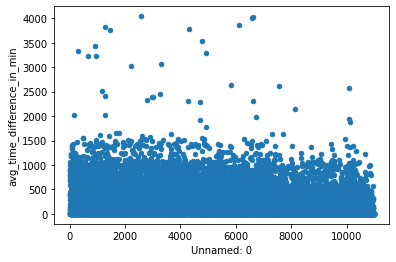

In [ ]:
df.plot.scatter('Unnamed: 0','avg_time_difference_in_min')


 We will scale down both these features to a range between 0 and 1. This is required to create a explainable visualization (it will become way too stretched otherwise). As for this data, using the same approach will take much more time to create the visualization.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Unnamed: 0','avg_time_difference_in_min']] = scaler.fit_transform(df[['Unnamed: 0','avg_time_difference_in_min']])
df[['Unnamed: 0','avg_time_difference_in_min']].head()

,Unnamed: 0,avg_time_difference_in_min
0,0.000000,0.249949
1,0.000091,0.020432
2,0.000182,0.195783
3,0.000273,0.173178
4,0.000364,0.201528


Store these values in the NumPy array for using in our models later:

In [ ]:
X1 = df['Unnamed: 0'].values.reshape(-1,1)
X2 = df['avg_time_difference_in_min'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

Again, we will create a dictionary. But this time, we will add some more models to it and see how each model predicts outliers.

You can set the value of the outlier fraction according to your problem and your understanding of the data. In our example, I want to detect 6% observations that are not similar to the rest of the data. So, I’m going to set the value of outlier fraction as 0.06.

In [ ]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.06
# Define three outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
}

Now, we will fit the data to each model one by one and see how differently each model predicts the outliers.

[1.28747082e+08 1.67066336e+09 1.31306220e+09 ... 6.35458114e+13
 2.02561144e+10 3.51661017e+11]
OUTLIERS :  659 INLIERS :  10325 Angle-based Outlier Detector (ABOD)


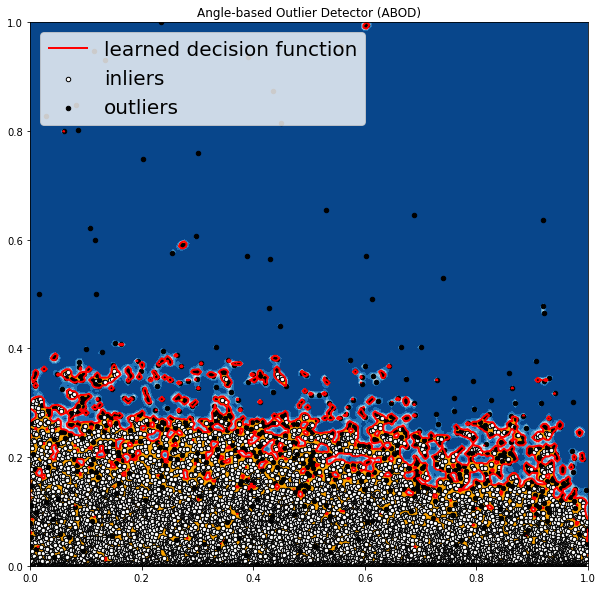

[-0.0558748  -0.00184779 -0.02141452 ...  0.04837876  0.0392777
  0.04711018]
OUTLIERS :  659 INLIERS :  10325 Isolation Forest


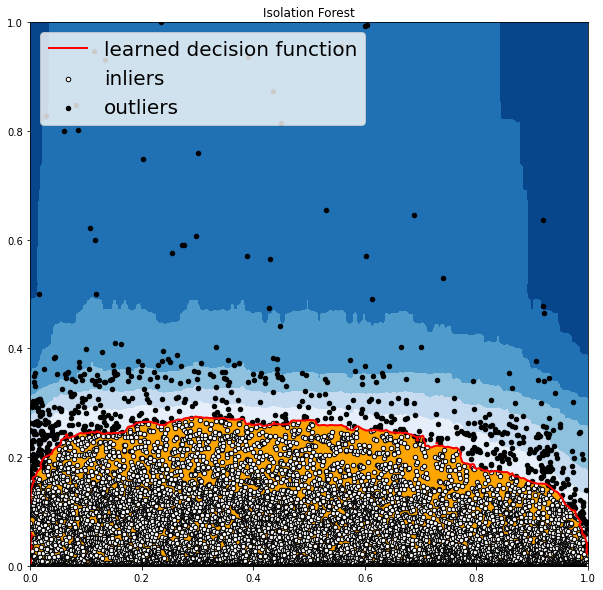

[-0.00909023 -0.00546536 -0.00927762 ... -0.00046588 -0.0031526
 -0.00076251]
OUTLIERS :  498 INLIERS :  10486 K Nearest Neighbors (KNN)


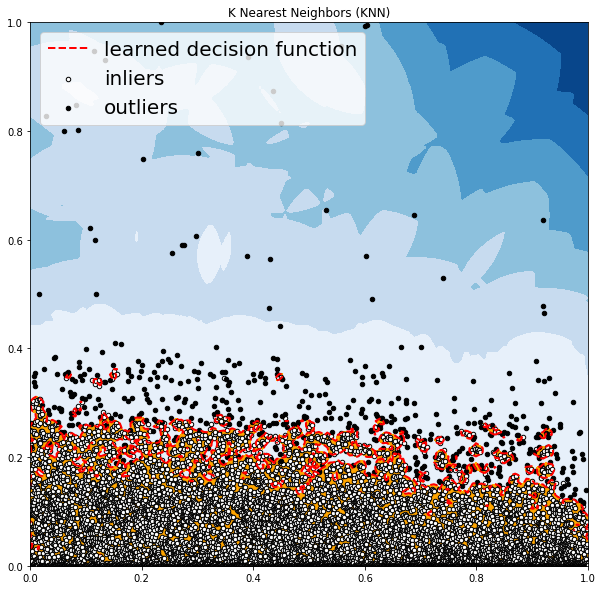

In [ ]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
    print(scores_pred)
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Unnamed: 0'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['avg_time_difference_in_min'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Unnamed: 0'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['avg_time_difference_in_min'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [ ]:
print("Accuracy = ",metrics.accuracy_score(data['extreme_user'],y_pred))

Accuracy =  0.530863073561544


In [ ]:
print("Precision = ",metrics.precision_score(data['extreme_user'],y_pred))

Precision =  0.0
